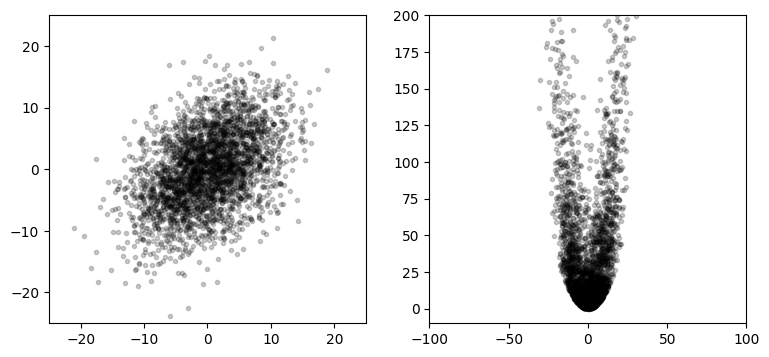

In [1]:
%matplotlib inline

#format the book
import book_format
book_format.set_style()

import kf_book.pf_internal as pf_internal
pf_internal.plot_monte_carlo_ukf()

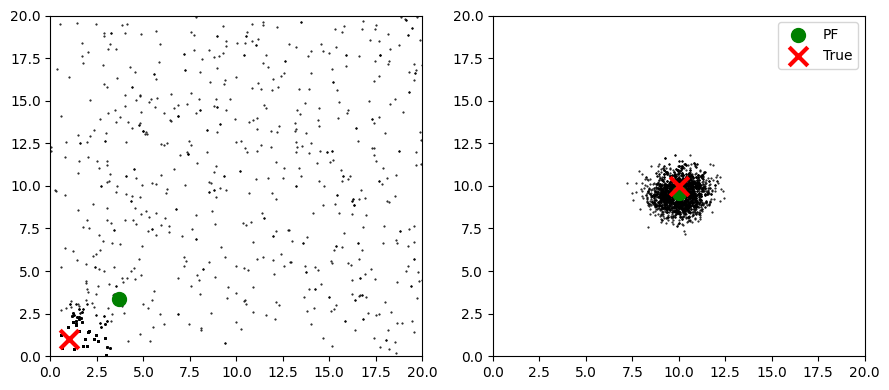

In [2]:
pf_internal.show_two_pf_plots()

mean pi(N=20000)= 3.1684
err  pi(N=20000)= -0.0268


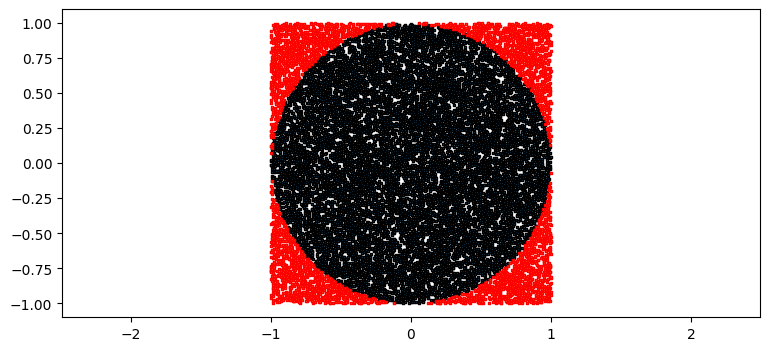

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform 

N = 20000  # number of points
radius = 1.
area = (2*radius)**2

pts = uniform(-1, 1, (N, 2))

# distance from (0,0) 
dist = np.linalg.norm(pts, axis=1)
in_circle = dist <= 1

pts_in_circle = np.count_nonzero(in_circle)
pi = 4 * (pts_in_circle / N)

# plot results
plt.scatter(pts[in_circle,0], pts[in_circle,1], 
            marker=',', edgecolor='k', s=1)
plt.scatter(pts[~in_circle,0], pts[~in_circle,1], 
            marker=',', edgecolor='r', s=1)
plt.axis('equal')

print(f'mean pi(N={N})= {pi:.4f}')
print(f'err  pi(N={N})= {np.pi-pi:.4f}')

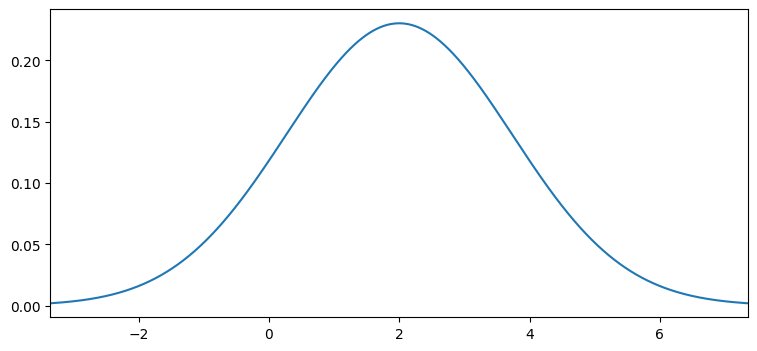

In [4]:
from filterpy.stats import plot_gaussian_pdf
plot_gaussian_pdf(mean=2, variance=3);

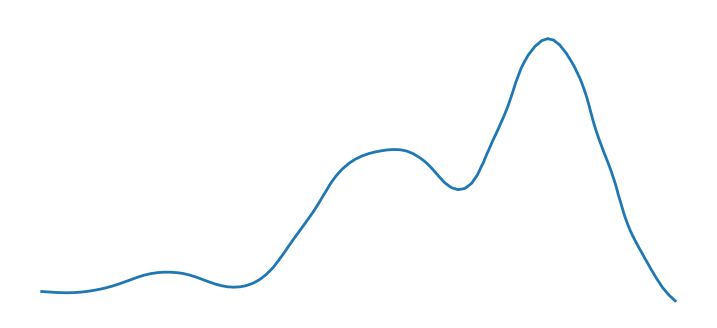

In [5]:
pf_internal.plot_random_pd()

In [6]:
from numpy.random import uniform

def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

In [7]:
create_uniform_particles((0,1), (0,1), (0, np.pi*2), 4)

array([[0.772, 0.336, 4.171],
       [0.333, 0.34 , 4.319],
       [0.6  , 0.274, 5.02 ],
       [0.054, 0.022, 5.034]])

In [10]:
def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist
    
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize
    
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

particles = create_uniform_particles((0,1), (0,1), (0, 5), 1000)
weights = np.array([.25]*1000)
estimate(particles, weights)

def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)

def neff(weights):
    return 1. / np.sum(np.square(weights))

def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

final position error, variance:
	 [-0.106  0.106] [0.009 0.008]


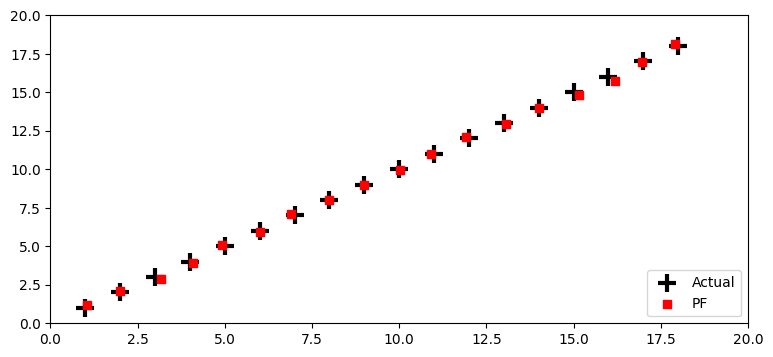

In [11]:
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats

def run_pf1(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    
    plt.figure()
   
    # create particles and weights
    if initial_x is not None:
        particles = create_gaussian_particles(
            mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(particles[:, 0], particles[:, 1], 
                    alpha=alpha, color='g')
    
    xs = []
    robot_pos = np.array([0., 0.])
    for x in range(iters):
        robot_pos += (1, 1)

        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + 
              (randn(NL) * sensor_std_err))

        # move diagonally forward to (x+1, x+1)
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
        
        # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], 
                        color='k', marker=',', s=1)
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',
                         color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    xs = np.array(xs)
    #plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    plt.show()

from numpy.random import seed
seed(2) 
run_pf1(N=5000, plot_particles=False)

final position error, variance:
	 [-0.019 -0.005] [0.005 0.006]


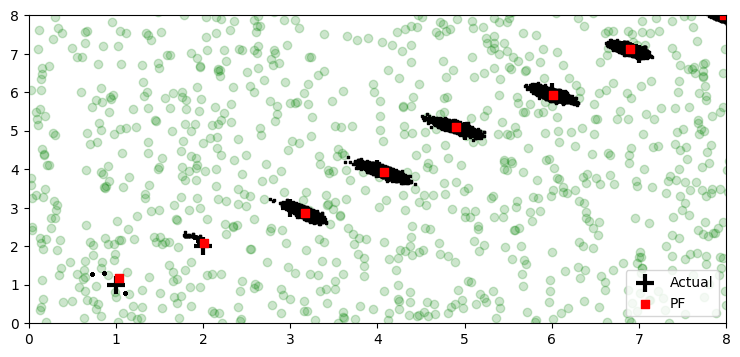

In [12]:
seed(2)
run_pf1(N=5000, iters=8, plot_particles=True, 
        xlim=(0,8), ylim=(0,8))

final position error, variance:
	 [-0.17   0.084] [0.005 0.005]


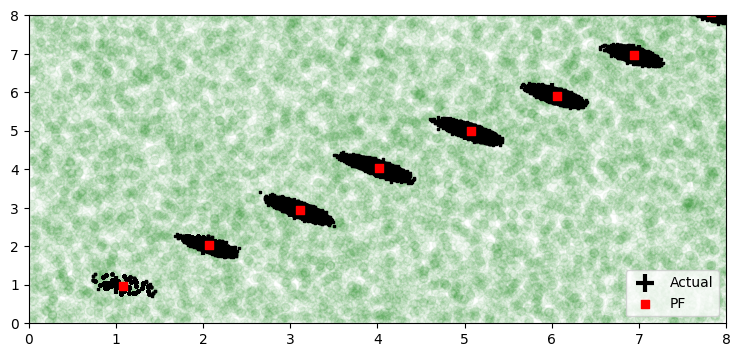

In [13]:
seed(2) 
run_pf1(N=100000, iters=8, plot_particles=True, 
        xlim=(0,8), ylim=(0,8))

final position error, variance:
	 [ -2.688 -31.47 ] [47.065 47.03 ]


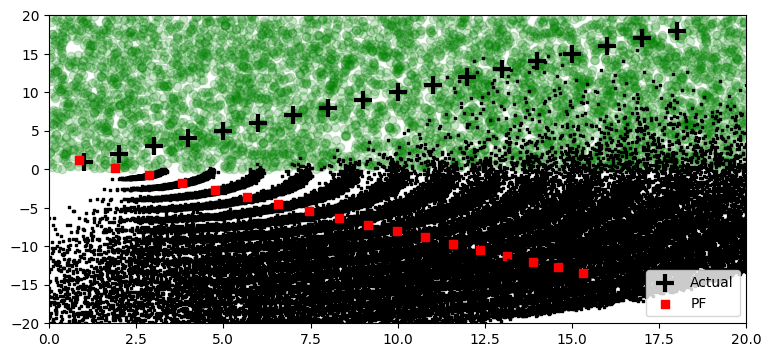

In [14]:
seed(6) 
run_pf1(N=5000, plot_particles=True, ylim=(-20, 20))

final position error, variance:
	 [ 0.035 -0.077] [0.007 0.009]


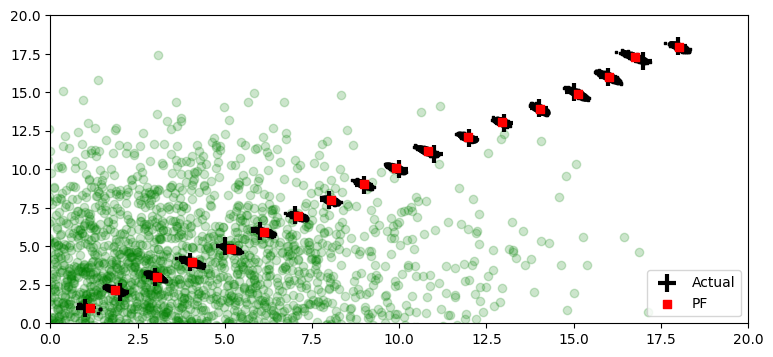

In [16]:
seed(6) 
run_pf1(N=5000, plot_particles=True, initial_x=(1,1, np.pi/4))

cumulative sume is [0.1 0.3 0.4 1. ]


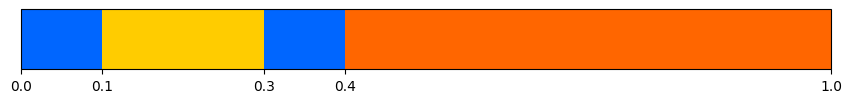

In [18]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill(1.0 / len(weights))

from kf_book.pf_internal import plot_cumsum
print('cumulative sume is', np.cumsum([.1, .2, .1, .6]))
plot_cumsum([.1, .2, .1, .6])

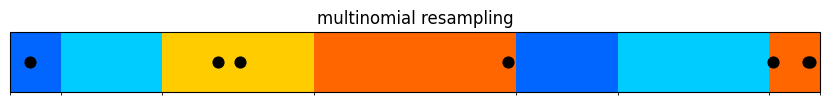

In [20]:
def multinomal_resample(weights):
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.  # avoid round-off errors
    return np.searchsorted(cumulative_sum, random(len(weights)))    

from kf_book.pf_internal import plot_multinomial_resample
plot_multinomial_resample([.1, .2, .3, .4, .2, .3, .1])

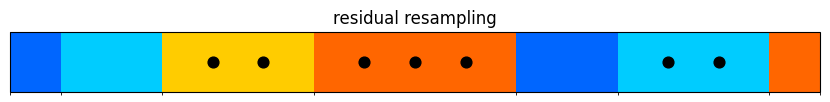

In [22]:
def residual_resample(weights):
    N = len(weights)
    indexes = np.zeros(N, 'i')

    # take int(N*w) copies of each weight
    num_copies = (N*np.asarray(weights)).astype(int)
    k = 0
    for i in range(N):
        for _ in range(num_copies[i]): # make n copies
            indexes[k] = i
            k += 1

    # use multinormial resample on the residual to fill up the rest.
    residual = w - num_copies     # get fractional part
    residual /= sum(residual)     # normalize
    cumulative_sum = np.cumsum(residual)
    cumulative_sum[-1] = 1. # ensures sum is exactly one
    indexes[k:N] = np.searchsorted(cumulative_sum, random(N-k))

    return indexes

from kf_book.pf_internal import plot_residual_resample
plot_residual_resample([.1, .2, .3, .4, .2, .3, .1])

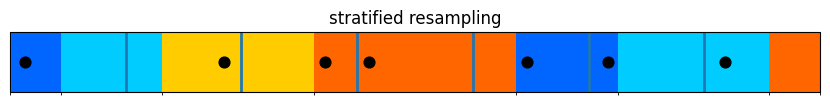

In [24]:
from kf_book.pf_internal import plot_stratified_resample
plot_stratified_resample([.1, .2, .3, .4, .2, .3, .1])

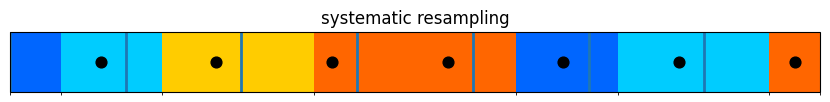

In [25]:
def stratified_resample(weights):
    N = len(weights)
    # make N subdivisions, chose a random position within each one
    positions = (random(N) + range(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

from kf_book.pf_internal import plot_systematic_resample
plot_systematic_resample([.1, .2, .3, .4, .2, .3, .1])

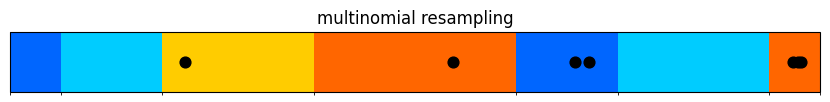

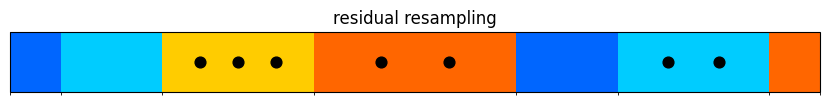

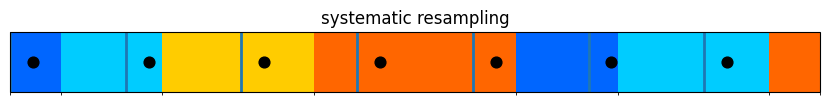

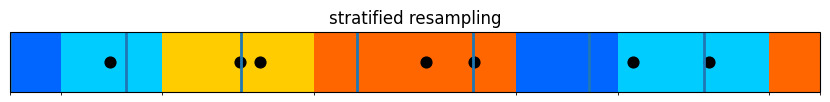

In [26]:
def systematic_resample(weights):
    N = len(weights)

    # make N subdivisions, choose positions 
    # with a consistent random offset
    positions = (np.arange(N) + random()) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

a = [.1, .2, .3, .4, .2, .3, .1]
np.random.seed(4)
plot_multinomial_resample(a)
plot_residual_resample(a)
plot_systematic_resample(a)
plot_stratified_resample(a)